In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.integrate import odeint
from sympy import *
init_printing(use_unicode=False, wrap_line=True)

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

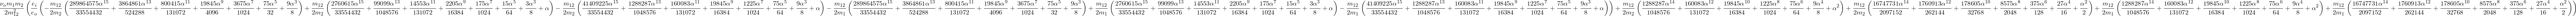

In [48]:
# Define symbols for orbital elements and constants
mu_i, mu_o, a_i, a_o, e_i, e_o, m3 = \
symbols("\mu_i,\mu_o,a_i,a_o,e_i,e_o,m_3", positive=True, real=True)

def Ajm(alpha, beta1, beta2, j, m):
    """
    Calculates the coefficient Ajm in the literal expansion
    presented in RM2013.
    """
    if (m == 0):
        xi_m = Rational(1,2)
    else:
        xi_m = 1
        
    a1, a2, p_min, p = symbols("\\alpha_1  \\alpha2 p_{min} p", real=True)
    a1 = beta1*alpha; a2 = beta2*alpha
    
    def B_jm(a):
        p_min = Max(0, floor(Rational(1, 2)*(j - m + 1)))
        E_pjm = lambda p: 2*factorial(2*m + 2*p)*factorial(m + 2*p)*factorial(2*p)\
            /(4**(2*p + m)*factorial(j)*factorial(m + 2*p - j)*(factorial(p)*factorial(m + p))**2)
        
        return Sum(E_pjm(p)*alpha**(m + 2*p), (p, p_min, oo))
    
    return xi_m*Rational(1, 2)*(B_jm(a1)/beta1 - B_jm(a2)/beta2)
    
beta1, beta2, alpha = symbols("\\beta_1  \\beta_2 \\alpha", real=True)

m1, m2, m12, m123, nu_o, nu_i = symbols(r'm_1 m_2 m_{12} m_{123} \nu_o \nu_i', positive=True, real=True)
omega_o = symbols(r"\omega_o", real=True)

edot = -Rational(1,2)*nu_o*(m1*m2/m12**2)*e_i*(Ajm(alpha, beta1, beta2, 0, 1)\
                                              - Ajm(alpha, beta1, beta2, 1, 1)\
                                              - Ajm(alpha, beta1, beta2, 2, 1))*sin(omega_o)

wdot = Rational(1,2)*nu_o*(m1*m2/m12**2)*(2*(Ajm(alpha, beta1, beta2, 1, 0) + Ajm(alpha, beta1, beta2, 2, 0))\
    + e_i/e_o*(Ajm(alpha, beta1, beta2, 0, 1) - Ajm(alpha, beta1, beta2, 1, 1) - Ajm(alpha, beta1, beta2, 2, 1))\
                                         *cos(omega_o))


wdot = wdot.subs(oo, 7).doit()
wdot = wdot.subs({beta1: m1/m12,
          beta2: -m2/m12
          })
wdot = wdot.subs({omega_o: 0})
wdot

In [50]:
print(solve(wdot, e_o))

[5*\alpha*e_i*(21900879*\alpha**12 + 19027008*\alpha**10 + 16144128*\alpha**8 + 13246464*\alpha**6 + 10321920*\alpha**4 + 7340032*\alpha**2 + 4194304)/(16*(6441435*\alpha**12 + 5549544*\alpha**10 + 4656960*\alpha**8 + 3763200*\alpha**6 + 2867200*\alpha**4 + 1966080*\alpha**2 + 1048576))]


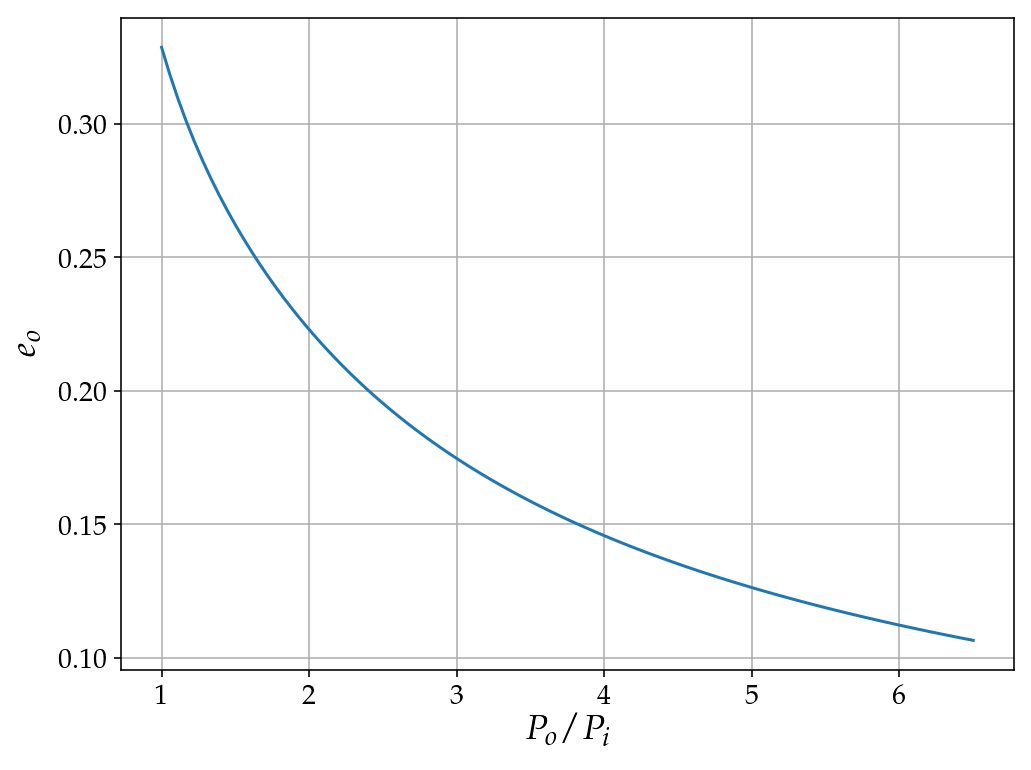

In [51]:
n = np.linspace(1, 6.5, 100)

nu_o_= 2*np.pi/(n*20)
nu_i_ = 2*np.pi/20
m1_= 1.2
m2_ = 0.6*1.2
m3_ = 1e-03
e_i_ = 0.3

alpha_ = ((m1_ + m2_)/(m1_ + m2_ + m3_))**(1/3.)*(nu_o_/nu_i_)**(2/3.)

e_o = lambda alpha_, e_i_: 5*alpha_*e_i_*(21900879*alpha_**12 + 19027008*alpha_**10 + 16144128*alpha_**8 + 13246464*alpha_**6 + 10321920*alpha_**4 + 7340032*alpha_**2 + 4194304)/(16*(6441435*alpha_**12 + 5549544*alpha_**10 + 4656960*alpha_**8 + 3763200*alpha_**6 + 2867200*alpha_**4 + 1966080*alpha_**2 + 1048576))
e_o_ = e_o(alpha_, e_i_)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(n, e_o_)
ax.set_xlabel(r'$P_o/P_i$')
ax.set_ylabel(r'$e_{o}$')
ax.grid(True)

In [53]:
print(e_o_[-1])

0.106511481438


## Test with rebound

In [75]:
import rebound

sim = rebound.Simulation()
sim.add(m=m1_)
sim.add(m=m2_, P=2*np.pi*(20/365.25), e=e_i_) 
sim.add(m=m3_, P=2*np.pi*(20.5*20/365.25), e=0.0133354317858) 

sim.move_to_com() # Moves to the center of momentum frame 
sim.integrator = "ias15"
ps = sim.particles
orb = sim.calculate_orbits()

# Integrate for 1000 years
times = 2*np.pi*np.linspace(0, 500, 1000)

e = np.zeros(1000)
omega = np.zeros(1000)

for i, time in enumerate(times):
    sim.integrate(time)
    orbits = sim.calculate_orbits()
    e[i] = orbits[1].e
    omega[i] = orbits[1].omega

0.0121720804891


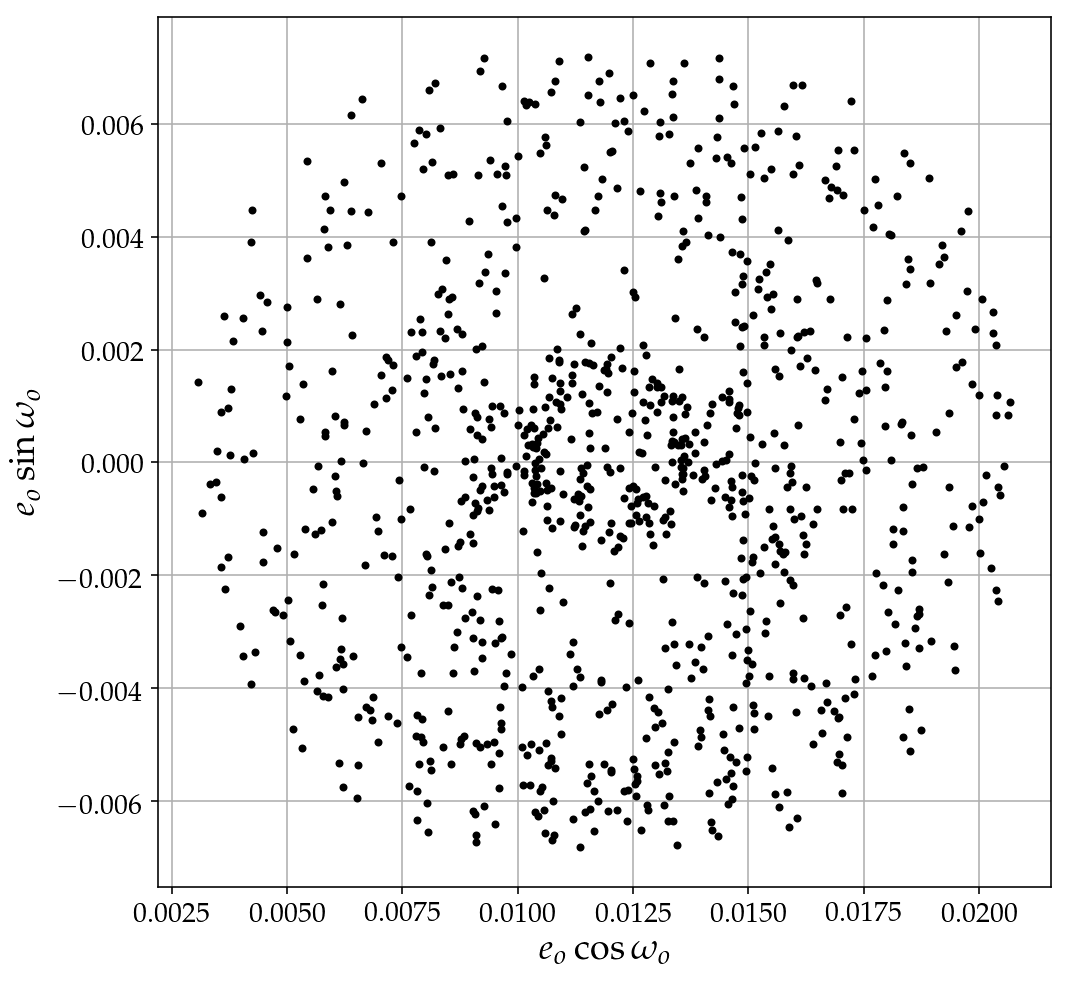

In [76]:
ecosomega = e*np.cos(omega)
esinomega = e*np.sin(omega)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ecosomega, esinomega, 'k.')
ax.grid(True)
ax.set_xlabel(r'$e_o\cos \omega_o$')
ax.set_ylabel(r'$e_o\sin \omega_o$')


# Calculate centroid
x_cen = np.mean(ecosomega)
y_cen = np.mean(esinomega)
e_forced = np.sqrt(x_cen**2 + y_cen**2)
print(e_forced)

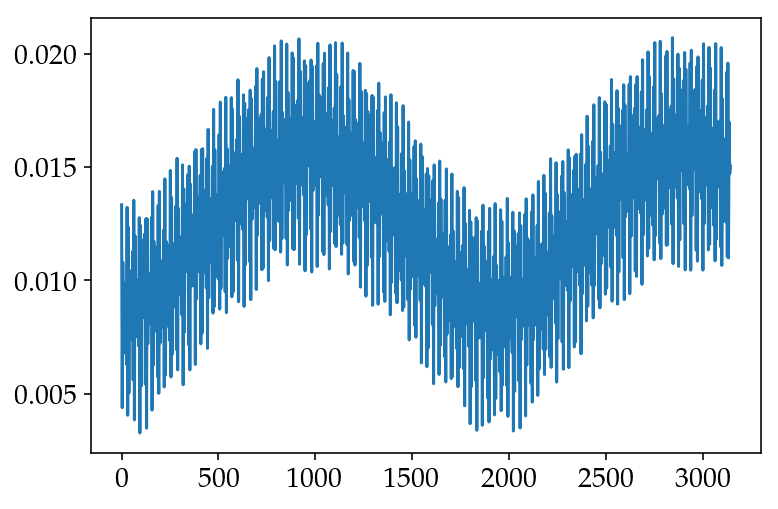

In [77]:
plt.plot(times, e)